In [ ]:
from pyspark.sql.functions import col, sum as sum_

# Load the table into a DataFrame
raw_hr_attr = spark.table("workspace.default.raw_hr_employee_attrition")
# Substituir valores nulos por 0 em todo o DataFrame
raw_hr_attr = raw_hr_attr.fillna(0)


In [ ]:
from pyspark.sql.functions import sum as sum_, col, round
from pyspark.sql.functions import max as max_, min as min_, avg, expr

# Analise inicial de colunas numericas
# Mostra min, max, media e mediana
def basic_stats(df, column):

    stats = df.agg(
        min_(column).alias("Min_" + column),
        max_(column).alias("Max_" + column),
        avg(column).alias("Average_" + column),
        expr("percentile_approx("+ column +", 0.5)").alias("Median_" + column)
    )

    display(stats)


# Analise de colunas categoricas
def counting_stats(df, column, retorna=False, exibe=True):

    total_count = df.count()
    conta = df.groupBy(column).count()
    conta = conta.withColumn("percentage", round((col("count") / total_count) * 100,2))
    if exibe :
        display(conta)
    if retorna:
        return conta

def plot_perc_relation_chart(df, category_col):
    import pandas as pd
    import matplotlib.pyplot as plt

    pdf = df.select(category_col, "perc_1", "perc_2", "relation").toPandas()
    pdf = pdf.sort_values(category_col)

    fig, ax1 = plt.subplots(figsize=(8,5))

    bar_width = 0.35
    x = range(len(pdf[category_col]))

    ax1.bar([i - bar_width/2 for i in x], pdf["perc_1"], width=bar_width, label="perc_1")
    ax1.bar([i + bar_width/2 for i in x], pdf["perc_2"], width=bar_width, label="perc_2")
    ax1.set_xlabel(category_col)
    ax1.set_ylabel("Percentage")
    ax1.set_xticks(x)
    ax1.set_xticklabels(pdf[category_col], rotation=45)
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.plot(x, pdf["relation"], color="red", marker="o", label="relation")
    ax2.set_ylabel("Relation (%)", color="red")
    ax2.tick_params(axis='y', labelcolor='red')

    fig.tight_layout()
    plt.title(str(category_col))
    plt.show()

# Analise de colunas categoricas
def compare_stats(df_1, df_2, column):

    conta_1 = counting_stats(df_1, column, retorna=True, exibe=False)
    conta_2 = counting_stats(df_2, column, retorna=True, exibe=False)

    from pyspark.sql.functions import coalesce

    joined = conta_1.alias("a").join(
        conta_2.alias("b"),
        on=col(f"a.{column}") == col(f"b.{column}"),
        how="outer"
    ).select(
        coalesce(col(f"a.{column}"), col(f"b.{column}")).alias(column),
        col("a.percentage").alias("perc_1"),
        col("b.percentage").alias("perc_2")
    )

    result = joined.withColumn(
        "relation", round(((col("perc_2") / col("perc_1")) -1)*100, 2)
    )

    display(result)
    plot_perc_relation_chart(result, column)



## Variáveis Disponíveis:
- **Demográficas**: Age, Gender, MaritalStatus, Education, EducationField
- **Profissionais**: Department, JobRole, JobLevel, JobInvolvement, YearsAtCompany
- **Compensação**: MonthlyIncome, PercentSalaryHike, StockOptionLevel
- **Satisfação**: JobSatisfaction, EnvironmentSatisfaction, RelationshipSatis-
faction
- **Work-Life**: OverTime, WorkLifeBalance, BusinessTravel, Distance-
FromHome
- **Performance**: PerformanceRating, TrainingTimesLastYear
- **Target**: Attrition (Yes/No)

In [ ]:
# Separando em 2 outros DataFrames, um com e outro sem attrition
attrition_yes_df = raw_hr_attr.filter(col("Attrition") == "Yes")
attrition_no_df = raw_hr_attr.filter(col("Attrition") == "No")
# spark.sql("SELECT * FROM raw_hr_employee_attrition "\
#     "where Attrition == 'No'")

display(attrition_yes_df)
display(attrition_no_df)


Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
28,Yes,Travel_Rarely,103,Research & Development,24,3,Life Sciences,1,19,3,Male,50,2,1,Laboratory Technician,3,Single,2028,12947,5,Y,Yes,14,3,2,80,0,6,4,3,4,2,0,3
36,Yes,Travel_Rarely,1218,Sales,9,4,Life Sciences,1,27,3,Male,82,2,1,Sales Representative,1,Single,3407,6986,7,Y,No,23,4,2,80,0,10,4,3,5,3,0,3
34,Yes,Travel_Rarely,699,Research & Development,6,1,Medical,1,31,2,Male,83,3,1,Research Scientist,1,Single,2960,17102,2,Y,No,11,3,3,80,0,8,2,3,4,2,1,3
32,Yes,Travel_Frequently,1125,Research & Development,16,1,Life Sciences,1,33,2,Female,72,1,1,Research Scientist,1,Single,3919,4681,1,Y,Yes,22,4,2,80,0,10,5,3,10,2,6,7
39,Yes,Travel_Rarely,895,Sales,5,3,Technical Degree,1,42,4,Male,56,3,2,Sales Representative,4,Married,2086,3335,3,Y,No,14,3,3,80,1,19,6,4,1,0,0,0
24,Yes,Travel_Rarely,813,Research & Development,1,3,Medical,1,45,2,Male,61,3,1,Research Scientist,4,Married,2293,3020,2,Y,Yes,16,3,1,80,1,6,2,2,2,0,2,0
50,Yes,Travel_Rarely,869,Sales,3,2,Marketing,1,47,1,Male,86,2,1,Sales Representative,3,Married,2683,3810,1,Y,Yes,14,3,3,80,0,3,2,3,3,2,0,2
26,Yes,Travel_Rarely,1357,Research & Development,25,3,Life Sciences,1,55,1,Male,48,1,1,Laboratory Technician,3,Single,2293,10558,1,Y,No,12,3,3,80,0,1,2,2,1,0,0,1


Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,4,Male,79,3,1,Laboratory Technician,4,Single,3068,11864,0,Y,No,13,3,3,80,0,8,2,2,7,7,3,6
59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,3,Female,81,4,1,Laboratory Technician,1,Married,2670,9964,4,Y,Yes,20,4,1,80,3,12,3,2,1,0,0,0
30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,4,Male,67,3,1,Laboratory Technician,3,Divorced,2693,13335,1,Y,No,22,4,2,80,1,1,2,3,1,0,0,0
38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,4,Male,44,2,3,Manufacturing Director,3,Single,9526,8787,0,Y,No,21,4,2,80,0,10,2,3,9,7,1,8
36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,3,Male,94,3,2,Healthcare Representative,3,Married,5237,16577,6,Y,No,13,3,2,80,2,17,3,2,7,7,7,7
35,No,Travel_Rarely,809,Research & Development,16,3,Medical,1,14,1,Male,84,4,1,Laboratory Technician,2,Married,2426,16479,0,Y,No,13,3,3,80,1,6,5,3,5,4,0,3
29,No,Travel_Rarely,153,Research & Development,15,2,Life Sciences,1,15,4,Female,49,2,2,Laboratory Technician,3,Single,4193,12682,0,Y,Yes,12,3,4,80,0,10,3,3,9,5,0,8


MaritalStatus,perc_1,perc_2,relation
Single,31.97,50.63,58.37
Divorced,22.24,13.92,-37.41
Married,45.78,35.44,-22.59


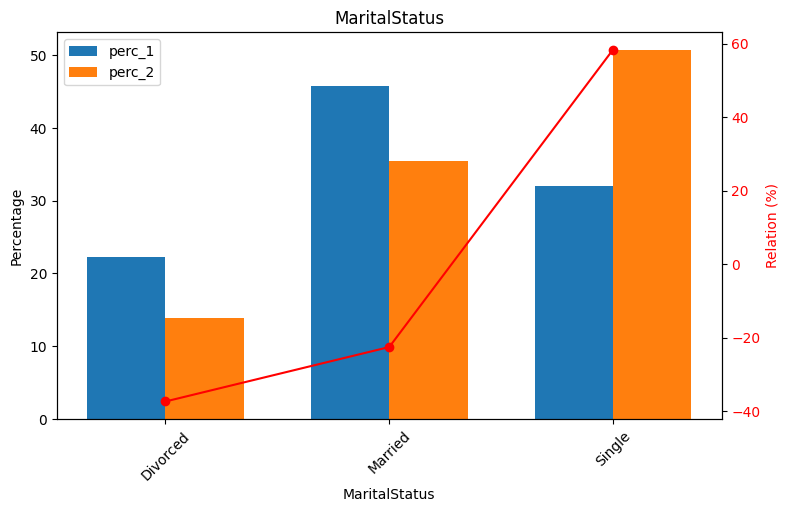

EducationField,perc_1,perc_2,relation
Other,5.58,4.64,-16.85
Medical,31.56,26.58,-15.78
Life Sciences,41.22,37.55,-8.9
Human Resources,1.84,2.95,60.33
Marketing,10.82,14.77,36.51
Technical Degree,8.98,13.5,50.33


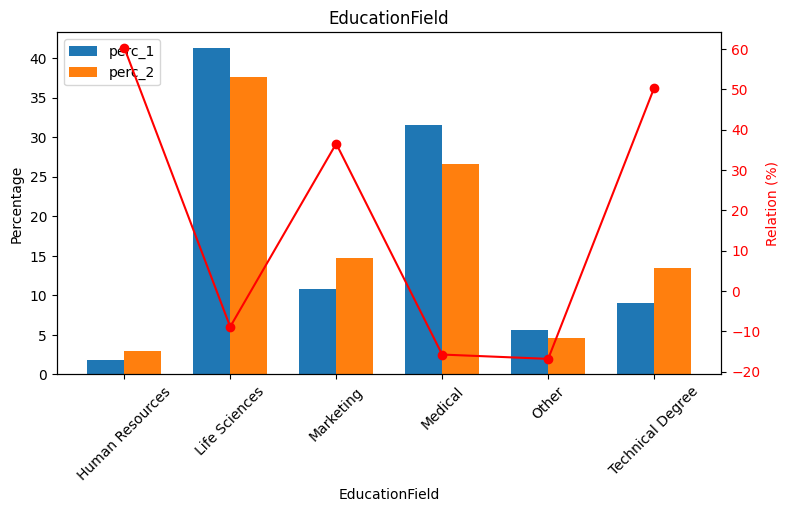

JobRole,perc_1,perc_2,relation
Research Director,5.44,0.84,-84.56
Manufacturing Director,9.86,4.22,-57.2
Sales Representative,5.65,13.92,146.37
Laboratory Technician,17.62,26.16,48.47
Human Resources,3.54,5.06,42.94
Research Scientist,19.86,19.83,-0.15
Manager,6.94,2.11,-69.6
Healthcare Representative,8.91,3.8,-57.35
Sales Executive,22.18,24.05,8.43


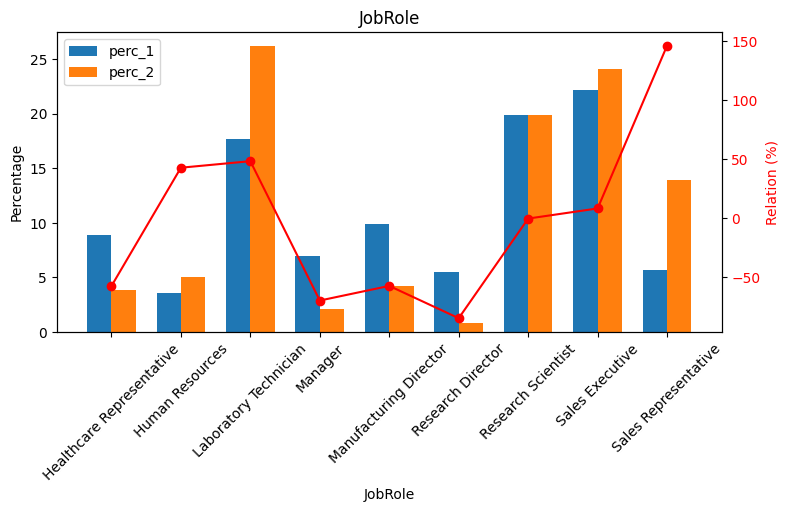

JobLevel,perc_1,perc_2,relation
2,36.33,21.94,-39.61
1,36.94,60.34,63.35
3,14.83,13.5,-8.97
5,4.69,2.11,-55.01
4,7.21,2.11,-70.74


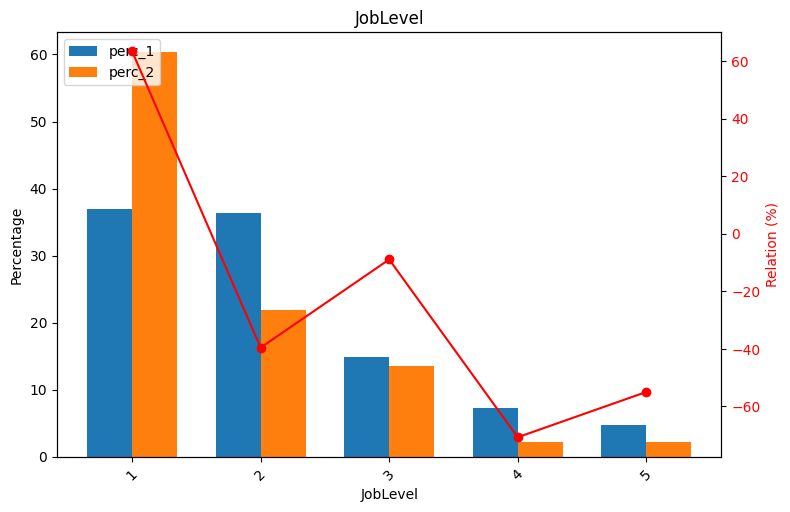

JobInvolvement,perc_1,perc_2,relation
2,25.51,29.96,17.44
1,5.65,11.81,109.03
3,59.05,52.74,-10.69
4,9.8,5.49,-43.98


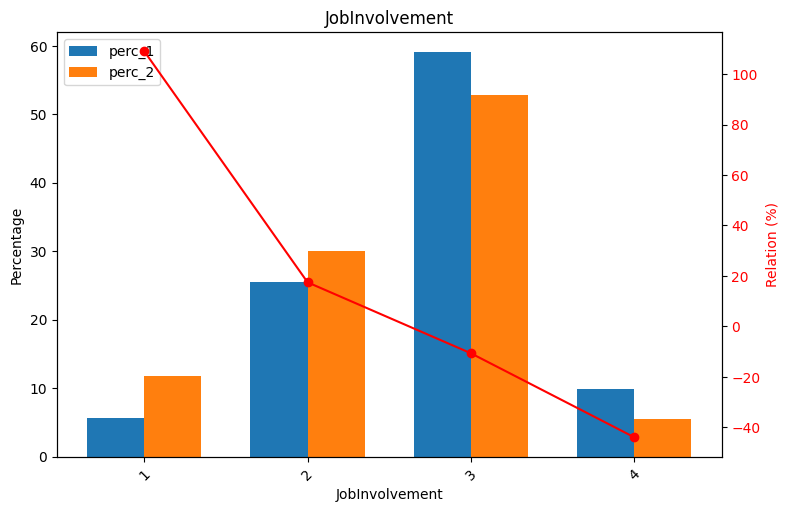

StockOptionLevel,perc_1,perc_2,relation
0,42.93,64.98,51.36
2,10.75,5.06,-52.93
1,40.54,23.63,-41.71
3,5.78,6.33,9.52


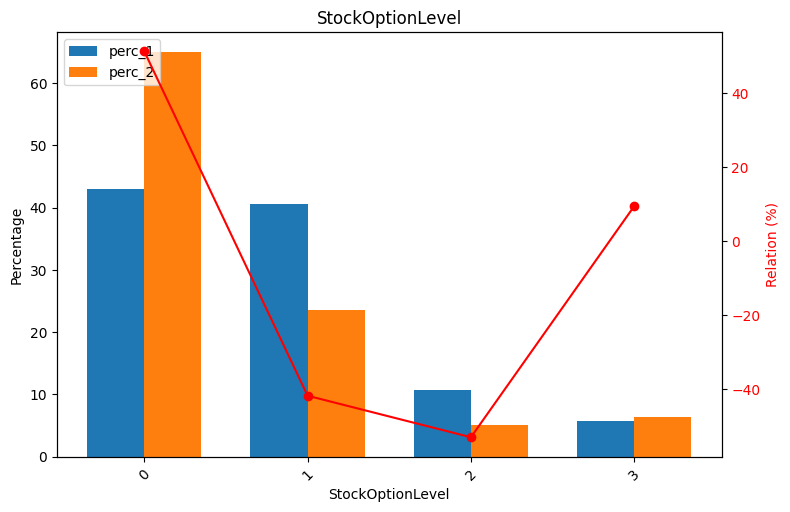

EnvironmentSatisfaction,perc_1,perc_2,relation
2,19.52,18.14,-7.07
1,19.32,30.38,57.25
3,30.82,26.16,-15.12
4,30.34,25.32,-16.55


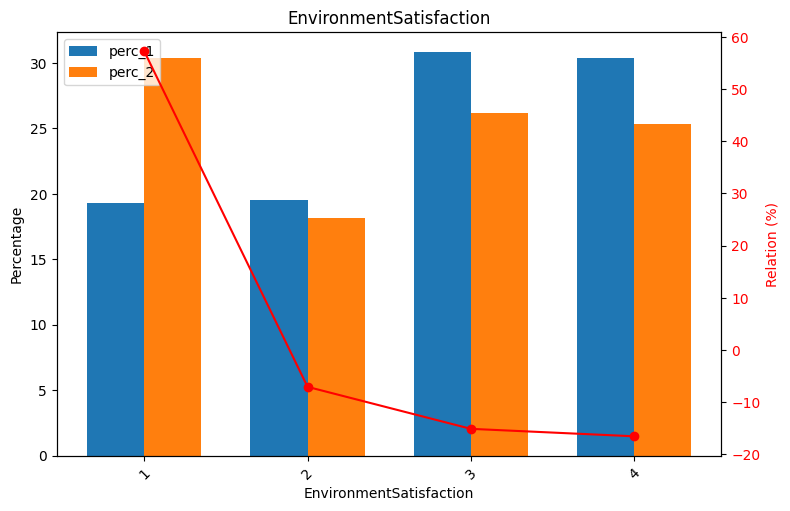

JobSatisfaction,perc_1,perc_2,relation
2,19.05,19.41,1.89
1,19.66,27.85,41.66
3,30.07,30.8,2.43
4,31.22,21.94,-29.72


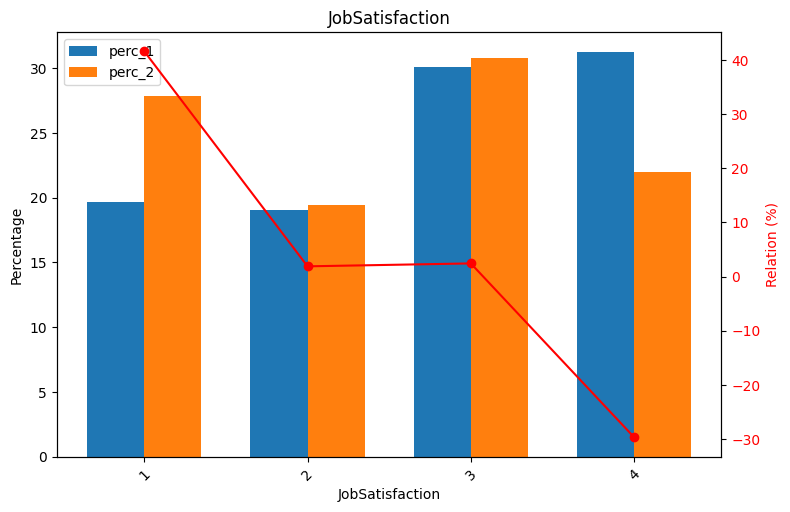

RelationshipSatisfaction,perc_1,perc_2,relation
2,20.61,18.99,-7.86
1,18.78,24.05,28.06
3,31.22,29.96,-4.04
4,29.39,27.0,-8.13


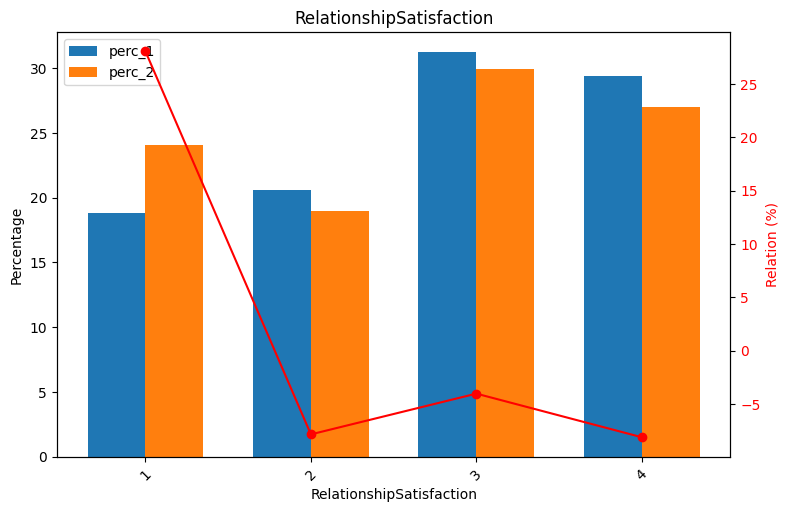

WorkLifeBalance,perc_1,perc_2,relation
2,23.4,24.47,4.57
1,5.44,10.55,93.93
3,60.75,53.59,-11.79
4,10.41,11.39,9.41


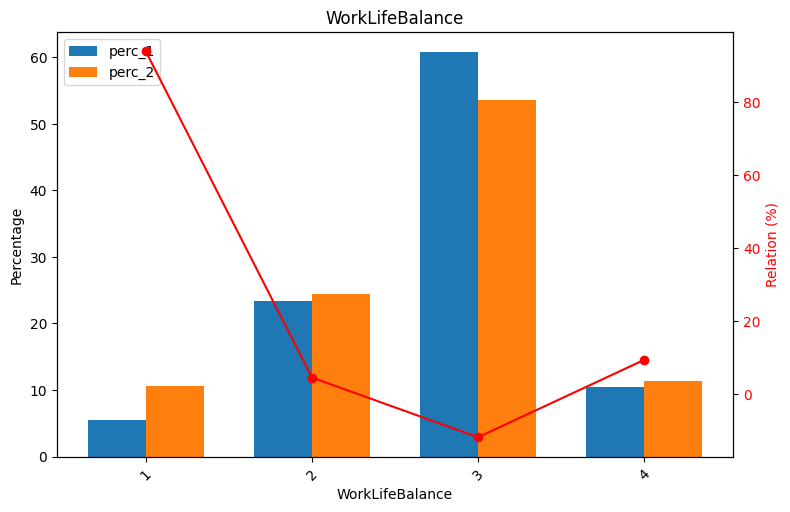

OverTime,perc_1,perc_2,relation
Yes,28.3,53.59,89.36
No,71.7,46.41,-35.27


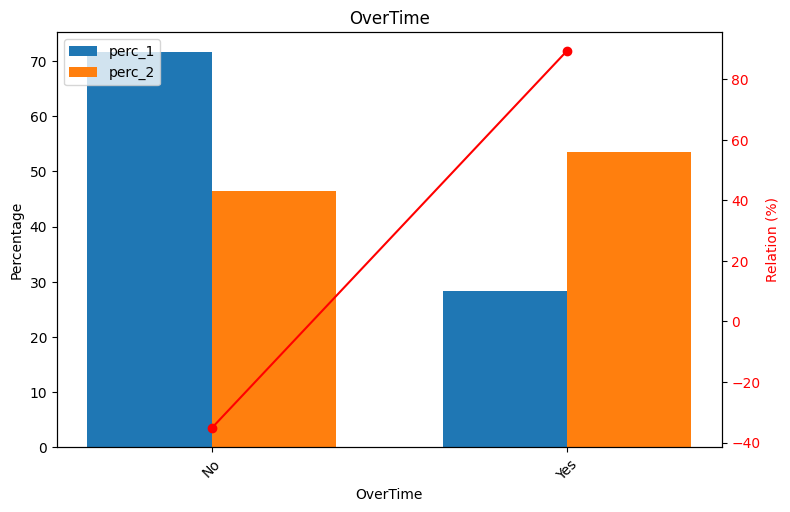

In [ ]:
# AquiSantina - com esta funcao se compara os dataframes totais com os com AttritionYes
# para variaves categorica. Estes dois aqui embaixo eis minhas conclusoes :
# Ser Single eh relevante, ficou 50% maior na massa COM atrito
# No EducationField as areas que tem maior aumento sao HR, Marketing e Techinical Degree
compare_stats(raw_hr_attr, attrition_yes_df, "MaritalStatus")
compare_stats(raw_hr_attr, attrition_yes_df, "EducationField")
compare_stats(raw_hr_attr, attrition_yes_df, "JobRole")
compare_stats(raw_hr_attr, attrition_yes_df, "JobLevel")
compare_stats(raw_hr_attr, attrition_yes_df, "JobInvolvement")
compare_stats(raw_hr_attr, attrition_yes_df, "StockOptionLevel")
compare_stats(raw_hr_attr, attrition_yes_df, "EnvironmentSatisfaction")
compare_stats(raw_hr_attr, attrition_yes_df, "JobSatisfaction")
compare_stats(raw_hr_attr, attrition_yes_df, "RelationshipSatisfaction")
compare_stats(raw_hr_attr, attrition_yes_df, "WorkLifeBalance")
compare_stats(raw_hr_attr, attrition_yes_df, "OverTime")


In [ ]:

# Separando as colunas que me interessam para montar as features

selected_columns = [
    "EmployeeNumber",
    "MaritalStatus",
    "JobLevel",
    "JobInvolvement",
    "YearsAtCompany",
    "MonthlyIncome",
    "StockOptionLevel",
    "JobSatisfaction",
    "EnvironmentSatisfaction",
    "OverTime",
    "WorkLifeBalance",
    "Attrition"
]

spark.sql("DROP TABLE IF EXISTS bz_hr_attr_features")

# Criando um nova tabela com as features
raw_hr_attr.select(selected_columns).write.format("delta").mode("overwrite").saveAsTable("bz_hr_attr_features")




In [ ]:
# Analise das variaveis demograficas e comparando com attrition yes e no
displayHTML("<h1>Age</h1>")
basic_stats(raw_hr_attr, "Age")
basic_stats(attrition_yes_df, "Age")

displayHTML("<h1>Gender</h1>")
counting_stats(raw_hr_attr, "Gender")
counting_stats(attrition_yes_df, "Gender")

displayHTML("<h1>MaritalStatus</h1>")
counting_stats(raw_hr_attr, "MaritalStatus")
counting_stats(attrition_yes_df, "MaritalStatus")

displayHTML("<h1>Education</h1>")
counting_stats(raw_hr_attr, "Education")
counting_stats(attrition_yes_df, "Education")

displayHTML("<h1>EducationField</h1>")
counting_stats(raw_hr_attr, "EducationField")
counting_stats(attrition_yes_df, "EducationField")


# Analise das variaveis de compensacao
# basic_stats(raw_hr_attr, "DailyRate")
# basic_stats(raw_hr_attr, "MonthlyIncome")
# basic_stats(raw_hr_attr, "MonthlyRate")

Age

Min_Age,Max_Age,Average_Age,Median_Age
18,60,36.923809523809524,36


Min_Age,Max_Age,Average_Age,Median_Age
18,58,33.607594936708864,32


Gender

Gender,count,percentage
Female,588,40.0
Male,882,60.0


Gender,count,percentage
Female,87,36.708860759493675
Male,150,63.29113924050633


MaritalStatus

MaritalStatus,count,percentage
Single,470,31.97278911564626
Divorced,327,22.244897959183675
Married,673,45.78231292517007


MaritalStatus,count,percentage
Single,120,50.63291139240506
Divorced,33,13.924050632911392
Married,84,35.44303797468354


Education

Education,count,percentage
2,282,19.183673469387756
1,170,11.564625850340136
3,572,38.91156462585034
5,48,3.2653061224489797
4,398,27.074829931972786


Education,count,percentage
2,44,18.565400843881857
1,31,13.080168776371309
3,99,41.77215189873418
5,5,2.109704641350211
4,58,24.47257383966245


EducationField

EducationField,count,percentage
Other,82,5.578231292517007
Medical,464,31.564625850340132
Life Sciences,606,41.224489795918366
Human Resources,27,1.8367346938775513
Marketing,159,10.816326530612246
Technical Degree,132,8.979591836734693


EducationField,count,percentage
Other,11,4.641350210970464
Medical,63,26.582278481012654
Life Sciences,89,37.552742616033754
Human Resources,7,2.9535864978902953
Marketing,35,14.767932489451477
Technical Degree,32,13.502109704641349


In [ ]:
# Analise das variaveis demograficas e comparando com attrition yes e no
# Profissionais: Department, JobRole, JobLevel, JobInvolvement, YearsAtCompany

displayHTML("<h1>Department</h1>")
counting_stats(raw_hr_attr, "Department")
counting_stats(attrition_yes_df, "Department")

displayHTML("<h1>JobRole</h1>")
counting_stats(raw_hr_attr, "JobRole")
counting_stats(attrition_yes_df, "JobRole")

displayHTML("<h1>JobLevel</h1>")
counting_stats(raw_hr_attr, "JobLevel")
counting_stats(attrition_yes_df, "JobLevel")

displayHTML("<h1>JobInvolvement</h1>")
counting_stats(raw_hr_attr, "JobInvolvement")
counting_stats(attrition_yes_df, "JobInvolvement")

displayHTML("<h1>YearsAtCompany</h1>")
basic_stats(raw_hr_attr, "YearsAtCompany")
basic_stats(attrition_yes_df, "YearsAtCompany")
basic_stats(attrition_no_df, "YearsAtCompany")

# Analise das variaveis de compensacao
# basic_stats(raw_hr_attr, "DailyRate")
# basic_stats(raw_hr_attr, "MonthlyIncome")
# basic_stats(raw_hr_attr, "MonthlyRate")

Department

Department,count,percentage
Research & Development,961,65.37414965986395
Sales,446,30.34013605442177
Human Resources,63,4.285714285714286


Department,count,percentage
Research & Development,133,56.118143459915615
Sales,92,38.81856540084388
Human Resources,12,5.063291139240507


JobRole

JobRole,count,percentage
Research Director,80,5.442176870748299
Manufacturing Director,145,9.863945578231291
Sales Representative,83,5.646258503401361
Laboratory Technician,259,17.61904761904762
Human Resources,52,3.537414965986395
Research Scientist,292,19.86394557823129
Manager,102,6.938775510204081
Healthcare Representative,131,8.91156462585034
Sales Executive,326,22.176870748299322


JobRole,count,percentage
Research Director,2,0.8438818565400843
Manufacturing Director,10,4.219409282700422
Sales Representative,33,13.924050632911392
Laboratory Technician,62,26.160337552742618
Human Resources,12,5.063291139240507
Research Scientist,47,19.831223628691983
Manager,5,2.109704641350211
Healthcare Representative,9,3.79746835443038
Sales Executive,57,24.050632911392405


JobLevel

JobLevel,count,percentage
2,534,36.3265306122449
1,543,36.93877551020408
3,218,14.829931972789115
5,69,4.6938775510204085
4,106,7.210884353741497


JobLevel,count,percentage
2,52,21.940928270042196
1,143,60.337552742616026
3,32,13.502109704641349
5,5,2.109704641350211
4,5,2.109704641350211


JobInvolvement

JobInvolvement,count,percentage
2,375,25.510204081632654
1,83,5.646258503401361
3,868,59.04761904761905
4,144,9.795918367346939


JobInvolvement,count,percentage
2,71,29.957805907172997
1,28,11.814345991561181
3,125,52.742616033755276
4,13,5.485232067510549


YearsAtCompany

Min_YearsAtCompany,Max_YearsAtCompany,Average_YearsAtCompany,Median_YearsAtCompany
0,40,7.0081632653061225,5


Min_YearsAtCompany,Max_YearsAtCompany,Average_YearsAtCompany,Median_YearsAtCompany
0,40,5.1308016877637135,3


Min_YearsAtCompany,Max_YearsAtCompany,Average_YearsAtCompany,Median_YearsAtCompany
0,37,7.369018653690187,6


In [ ]:
# Compensação: MonthlyIncome, PercentSalaryHike, StockOptionLevel
# Satisfação: JobSatisfaction, EnvironmentSatisfaction, RelationshipSatis- faction
# Work-Life: OverTime, WorkLifeBalance, BusinessTravel, Distance- FromHome
# Performance: PerformanceRating, TrainingTimesLastYear

displayHTML("<h1>MonthlyIncome</h1>")
basic_stats(raw_hr_attr, "MonthlyIncome")
basic_stats(attrition_yes_df, "MonthlyIncome")

displayHTML("<h1>PercentSalaryHike</h1>")
basic_stats(raw_hr_attr, "PercentSalaryHike")
basic_stats(attrition_yes_df, "PercentSalaryHike")

displayHTML("<h1>StockOptionLevel</h1>")
counting_stats(raw_hr_attr, "StockOptionLevel")
counting_stats(attrition_yes_df, "StockOptionLevel")

MonthlyIncome

Min_MonthlyIncome,Max_MonthlyIncome,Average_MonthlyIncome,Median_MonthlyIncome
1009,19999,6502.931292517007,4908


Min_MonthlyIncome,Max_MonthlyIncome,Average_MonthlyIncome,Median_MonthlyIncome
1009,19859,4787.0928270042195,3202


PercentSalaryHike

Min_PercentSalaryHike,Max_PercentSalaryHike,Average_PercentSalaryHike,Median_PercentSalaryHike
11,25,15.209523809523809,14


Min_PercentSalaryHike,Max_PercentSalaryHike,Average_PercentSalaryHike,Median_PercentSalaryHike
11,25,15.09704641350211,14


StockOptionLevel

StockOptionLevel,count,percentage
0,631,42.925170068027214
2,158,10.748299319727892
1,596,40.54421768707483
3,85,5.782312925170068


StockOptionLevel,count,percentage
0,154,64.9789029535865
2,12,5.063291139240507
1,56,23.628691983122362
3,15,6.329113924050633


In [ ]:
# Satisfação: JobSatisfaction, EnvironmentSatisfaction, RelationshipSatis- faction
# Work-Life: OverTime, WorkLifeBalance, BusinessTravel, Distance- FromHome
# Performance: PerformanceRating, TrainingTimesLastYear

displayHTML("<h1>JobSatisfaction</h1>")
counting_stats(raw_hr_attr, "JobSatisfaction")
counting_stats(attrition_yes_df, "JobSatisfaction")

displayHTML("<h1>EnvironmentSatisfaction</h1>")
counting_stats(raw_hr_attr, "EnvironmentSatisfaction")
counting_stats(attrition_yes_df, "EnvironmentSatisfaction")

displayHTML("<h1>RelationshipSatisfaction</h1>")
counting_stats(raw_hr_attr, "RelationshipSatisfaction")
counting_stats(attrition_yes_df, "RelationshipSatisfaction")

JobSatisfaction

JobSatisfaction,count,percentage
2,280,19.047619047619047
1,289,19.65986394557823
3,442,30.068027210884352
4,459,31.22448979591837


JobSatisfaction,count,percentage
2,46,19.40928270042194
1,66,27.848101265822784
3,73,30.801687763713083
4,52,21.940928270042196


EnvironmentSatisfaction

EnvironmentSatisfaction,count,percentage
2,287,19.523809523809526
1,284,19.319727891156464
3,453,30.816326530612244
4,446,30.34013605442177


EnvironmentSatisfaction,count,percentage
2,43,18.143459915611814
1,72,30.37974683544304
3,62,26.160337552742618
4,60,25.31645569620253


RelationshipSatisfaction

RelationshipSatisfaction,count,percentage
2,303,20.612244897959183
1,276,18.775510204081634
3,459,31.22448979591837
4,432,29.38775510204082


RelationshipSatisfaction,count,percentage
2,45,18.9873417721519
1,57,24.050632911392405
3,71,29.957805907172997
4,64,27.004219409282697


In [ ]:
# Work-Life: OverTime, WorkLifeBalance, BusinessTravel, Distance- FromHome
# Performance: PerformanceRating, TrainingTimesLastYear

displayHTML("<h1>OverTime</h1>")
counting_stats(raw_hr_attr, "OverTime")
counting_stats(attrition_yes_df, "OverTime")

displayHTML("<h1>WorkLifeBalance</h1>")
counting_stats(raw_hr_attr, "WorkLifeBalance")
counting_stats(attrition_yes_df, "WorkLifeBalance")

displayHTML("<h1>BusinessTravel</h1>")
counting_stats(raw_hr_attr, "BusinessTravel")
counting_stats(attrition_yes_df, "BusinessTravel")

displayHTML("<h1>DistanceFromHome</h1>")
basic_stats(raw_hr_attr, "DistanceFromHome")
basic_stats(attrition_yes_df, "DistanceFromHome")

OverTime

OverTime,count,percentage
Yes,416,28.29931972789116
No,1054,71.70068027210884


OverTime,count,percentage
Yes,127,53.58649789029536
No,110,46.41350210970464


WorkLifeBalance

WorkLifeBalance,count,percentage
2,344,23.401360544217688
1,80,5.442176870748299
3,893,60.74829931972789
4,153,10.408163265306122


WorkLifeBalance,count,percentage
2,58,24.47257383966245
1,25,10.548523206751055
3,127,53.58649789029536
4,27,11.39240506329114


BusinessTravel

BusinessTravel,count,percentage
Travel_Rarely,1043,70.95238095238095
Travel_Frequently,277,18.843537414965986
Non-Travel,150,10.204081632653061


BusinessTravel,count,percentage
Travel_Rarely,156,65.82278481012658
Travel_Frequently,69,29.11392405063291
Non-Travel,12,5.063291139240507


DistanceFromHome

Min_DistanceFromHome,Max_DistanceFromHome,Average_DistanceFromHome,Median_DistanceFromHome
1,29,9.19251700680272,7


Min_DistanceFromHome,Max_DistanceFromHome,Average_DistanceFromHome,Median_DistanceFromHome
1,29,10.632911392405063,9


In [ ]:
# Performance: PerformanceRating, TrainingTimesLastYear

displayHTML("<h1>PerformanceRating</h1>")
counting_stats(raw_hr_attr, "PerformanceRating")
counting_stats(attrition_yes_df, "PerformanceRating")

displayHTML("<h1>TrainingTimesLastYear</h1>")
counting_stats(raw_hr_attr, "TrainingTimesLastYear")
counting_stats(attrition_yes_df, "TrainingTimesLastYear")



PerformanceRating

PerformanceRating,count,percentage
3,1244,84.62585034013605
4,226,15.374149659863946


PerformanceRating,count,percentage
3,200,84.38818565400844
4,37,15.611814345991561


TrainingTimesLastYear

TrainingTimesLastYear,count,percentage
0,54,3.6734693877551026
2,547,37.2108843537415
1,71,4.829931972789116
3,491,33.40136054421769
5,119,8.095238095238095
4,123,8.36734693877551
6,65,4.421768707482993


TrainingTimesLastYear,count,percentage
0,15,6.329113924050633
2,98,41.35021097046413
1,9,3.79746835443038
3,69,29.11392405063291
5,14,5.9071729957805905
4,26,10.970464135021098
6,6,2.5316455696202533


In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Display the count of employees with the same EmployeeNumber
display(
    raw_hr_attr.groupBy("EmployeeNumber")
    .count()
    .filter(col("count") > 1)
)

# Display the first 5 rows of the DataFrame
display(raw_hr_attr.limit(5))

grouped_gender = raw_hr_attr.groupBy("Gender").count()
display(grouped_gender)

# Calculate the frequency of each department
department_counts = raw_hr_attr.groupBy("Department").count().orderBy("count", ascending=False)

# Convert to Pandas DataFrame for plotting
department_counts_pd = department_counts.toPandas()

# Create the bar graph
plt.figure(figsize=(10, 20))  # Set the figure size for better readability
bar_ax1 = department_counts_pd.plot(x="Department", y="count", kind="bar", color="skyblue")

#plt.bar(department_counts_pd['Department'], department_counts_pd['count'], color='skyblue')

# Add titles and labels
plt.title('Number of Employees per Department', fontsize=16)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Number of Employees', fontsize=12)

# Rotate x-axis labels for better readability if department names are long
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calculate the frequency of each department for attrition_yes_df
attrition_yes_department_counts = attrition_yes_df.groupBy("Department").count().orderBy("count", ascending=False)

# Convert to Pandas DataFrame for plotting
attrition_yes_department_counts_pd = attrition_yes_department_counts.toPandas()

# Plot the second bar with the count of lines grouping the Department column over the attrition_yes_df dataframe
attrition_yes_department_counts_pd.plot(x="Department", y="count", kind="bar", color="orange", ax=bar_ax1, position=1, width=0.4)

# Calculate the relation formed by the division of the count columns
relation_df = department_counts.alias("total").join(
    attrition_yes_department_counts.alias("attrition"),
    col("total.Department") == col("attrition.Department")
).select(
    col("total.Department"),
    (col("attrition.count") / col("total.count")).alias("Attrition_Rate")
)

display(relation_df)



# Display the plot
plt.show()

In [ ]:
from pyspark.sql.functions import when
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as sum_, col, round
from pyspark.sql.functions import expr


grouped_attrition_yes_gender = attrition_yes_df.groupBy("Gender").count()
display(grouped_attrition_yes_gender)


# Create age groups
attrition_yes_df = attrition_yes_df.withColumn(
    "AgeGroup",
    when(col("Age") < 20, "0-20")
    .when((col("Age") >= 20) & (col("Age") < 26), "20-25")
    .when((col("Age") >= 26) & (col("Age") < 30), "26-29")
    .when((col("Age") >= 30) & (col("Age") < 40), "30-40")
    .when((col("Age") >= 40) & (col("Age") < 50), "40-49")
    .when((col("Age") >= 50) & (col("Age") < 60), "50-59")
    .otherwise("60+")
)

# Group by age groups
grouped_attrition_yes_age_group = attrition_yes_df.groupBy("AgeGroup").count().orderBy("AgeGroup", ascending=True)


total_count = grouped_attrition_yes_age_group.agg(sum_("count").alias("total")).collect()[0]["total"]

grouped_attrition_yes_age_group = grouped_attrition_yes_age_group.withColumn(
    "Percentage",
    round((col("count") / total_count) * 100, 2)
)

display(grouped_attrition_yes_age_group)

# Create age groups
attrition_yes_df = attrition_yes_df.withColumn(
    "DistanceFromHomeGroup",
    when(col("DistanceFromHome") < 10, "0-10")
    .when((col("DistanceFromHome") >= 10) & (col("DistanceFromHome") < 20), "10-20")
    .otherwise(">20")
)

# Group by age groups
grouped_attrition_yes_dst_group = attrition_yes_df.groupBy("DistanceFromHomeGroup").count().orderBy("DistanceFromHomeGroup", ascending=True)


total_count_dst = grouped_attrition_yes_dst_group.agg(sum_("count").alias("total")).collect()[0]["total"]

grouped_attrition_yes_dst_group = grouped_attrition_yes_dst_group.withColumn(
    "Percentage",
    round((col("count") / total_count_dst) * 100, 2)
)

display(grouped_attrition_yes_dst_group)


grouped_attrition_yes_jobsat = attrition_yes_df.groupBy("JobSatisfaction").count().orderBy("JobSatisfaction", ascending=True)

total_count_jobsat = grouped_attrition_yes_jobsat.agg(sum_("count").alias("total")).collect()[0]["total"]

grouped_attrition_yes_jobsat = grouped_attrition_yes_jobsat.withColumn(
    "Percentage",
    round((col("count") / total_count_jobsat) * 100, 2)
)

display(grouped_attrition_yes_jobsat)

#AquiSantina - tem as minhas analises mais relevantes
# eu tenho usado muito histograma
# min, max, media e mediana para montar histograma

# display(grouped_attrition_yes_away)

In [ ]:
from pyspark.sql.functions import sum as sum_, col, round
from pyspark.sql.functions import max as max_, min as min_, avg, expr

# Filter the DataFrame for DistanceFromHomeGroup equals to "0-10"
filtered_df = attrition_yes_df.filter(col("DistanceFromHomeGroup") == "0-10")

# Create a column that calculates the AnnualBonus
filtered_df = filtered_df.withColumn("AnnualBonus", (col("MonthlyRate") * 12 - col("MonthlyIncome") * 12))


annual_bonus_stats = filtered_df.agg(
    max_("AnnualBonus").alias("MaxAnnualBonus"),
    min_("AnnualBonus").alias("MinAnnualBonus"),
    avg("AnnualBonus").alias("AvgAnnualBonus"),
    expr("percentile_approx(AnnualBonus, 0.5)").alias("MedianAnnualBonus")
)

display(filtered_df)
display(annual_bonus_stats)

# Create histogram bins for AnnualBonus (6 layers, max value 120000)
bin_edges = [0, 50000, 100000, 150000, 200000, 250000, 300000]

filtered_df = filtered_df.withColumn(
    "AnnualBonusBin",
    when(col("AnnualBonus") < bin_edges[1], "-0")
    .when((col("AnnualBonus") >= bin_edges[1]) & (col("AnnualBonus") < bin_edges[2]), "-50k")
    .when((col("AnnualBonus") >= bin_edges[2]) & (col("AnnualBonus") < bin_edges[3]), "50k-100k")
    .when((col("AnnualBonus") >= bin_edges[3]) & (col("AnnualBonus") < bin_edges[4]), "100k-150k")
    .when((col("AnnualBonus") >= bin_edges[4]) & (col("AnnualBonus") < bin_edges[5]), "200k-250k")
    .otherwise(">250k")
)

annual_bonus_histogram = (
    filtered_df.groupBy("AnnualBonusBin")
    .count()
    .orderBy("AnnualBonusBin")
)

display(annual_bonus_histogram)

marital_status_counts = filtered_df.groupBy("MaritalStatus").count().orderBy("count", ascending=False)
display(marital_status_counts)

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Display the count of employees with the same EmployeeNumber
display(
    raw_hr_attr.groupBy("EmployeeNumber")
    .count()
    .filter(col("count") > 1)
)

# Display the first 5 rows of the DataFrame
display(raw_hr_attr.limit(5))

# Calculate the frequency of each department
department_counts = raw_hr_attr.groupBy("Department").count().orderBy("count", ascending=False)

# Convert to Pandas DataFrame for plotting
department_counts_pd = department_counts.toPandas()

# Create the bar graph
plt.figure(figsize=(10, 20))  # Set the figure size for better readability
bar_ax1 = department_counts_pd.plot(x="Department", y="count", kind="bar", color="skyblue")

#plt.bar(department_counts_pd['Department'], department_counts_pd['count'], color='skyblue')


# Add titles and labels
plt.title('Number of Employees per Department', fontsize=16)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Number of Employees', fontsize=12)

# Rotate x-axis labels for better readability if department names are long
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calculate the average age per department
from pyspark.sql.functions import expr

# Calculate the median DistanceFromHome per department
average_age_per_department = raw_hr_attr.groupBy("Department").agg(expr("percentile_approx(DistanceFromHome, 0.5)").alias("median(DistanceFromHome)")).orderBy("median(DistanceFromHome)", ascending=False)
avrg_age_per_department_pd = average_age_per_department.toPandas()

display(average_age_per_department)

ax2 = bar_ax1.twinx()

# Changed 'kind' to 'line' and added 'marker' for better visualization of individual points
# avrg_age_per_department_pd.plot(kind='line', color='red', marker='o', linestyle='-')
ax2.plot(avrg_age_per_department_pd['Department'], avrg_age_per_department_pd['median(DistanceFromHome)'], color='red', marker='o', linestyle='-',
         linewidth=2, label='Median Satisfaction')

ax2.set_ylim(bottom=0, top=50) # Ensure y-axis starts from 0

# Add a legend to differentiate the bar and line plots
# zip joins x and y coordinates in pairs
for x,y in zip(avrg_age_per_department_pd['Department'], avrg_age_per_department_pd['median(DistanceFromHome)']):

    label = "{:.2f}".format(y)

    ax2.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


# Ensure layout is tight to prevent labels from being cut off
# plt.tight_layout()

# Display the plot
plt.show()